# Multi-Class Classification with Perceptron

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import random
np.random.seed(1)


You can use the following perceptron training code from the lecture:

In [4]:
def train(positive_examples, negative_examples, num_iterations = 100, learning_rate=1):
    num_dims = positive_examples.shape[1]
    weights = np.zeros(num_dims) # initialize weights
    
#    pos_count = positive_examples.shape[0]
#    neg_count = negative_examples.shape[0]
    
#    report_frequency = 10
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)
        
        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + learning_rate*pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - learning_rate*neg.reshape(weights.shape)
            
        #if i % report_frequency == 0:             
#        if i == num_iterations-1:
#            pos_out = np.dot(positive_examples, weights)
#            neg_out = np.dot(negative_examples, weights)        
#            pos_correct = (pos_out >= 0).sum() / float(pos_count)
#            neg_correct = (neg_out < 0).sum() / float(neg_count)
#            print("pos correct={}, neg correct={}".format(pos_correct,neg_correct))

    return weights

In [5]:
def train_norm(positive_examples, negative_examples, num_iterations = 100, learning_rate=1):
    #previously normalizes the examples by dividing by the norm of the array
    
    num_dims = positive_examples.shape[1]
    weights = np.zeros(num_dims) # initialize weights
    
    pos_norms = np.array([np.linalg.norm(positive_examples,axis=1)])
    pos_norms = pos_norms.transpose()
    norm_positive_examples = np.divide(positive_examples,pos_norms)
    neg_norms = np.array([np.linalg.norm(negative_examples,axis=1)])
    neg_norms = neg_norms.transpose()
    norm_negative_examples = np.divide(negative_examples,neg_norms)
    
    for i in range(num_iterations):
        pos = random.choice(norm_positive_examples)
        neg = random.choice(norm_negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + learning_rate*pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - learning_rate*neg.reshape(weights.shape)
            
    return weights

In [6]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

#accuracy(weights, test_x, test_labels)

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [7]:
#File https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz was donwloaded manually

In [8]:
import gzip
import pandas as pd
with gzip.open('mnist.pkl.gz', 'rb') as mnist_pickle:
    #MNIST = pickle.load(mnist_pickle,encoding='latin1')
    training_data, validation_data, test_data = pickle.load(mnist_pickle,encoding='latin1')
#MNIST = pd.read_pickle('mnist.pkl.gz',compression='gzip')



In [9]:
#We add a 1 at the end of every matrix to add a bias term to our model
train_with_bias=np.concatenate((training_data[0],np.ones((50000,1))),axis=1)
training_data_bias = (train_with_bias,training_data[1])
test_with_bias=np.concatenate((test_data[0],np.ones((10000,1))),axis=1)
test_data_bias = (test_with_bias,test_data[1])

In [10]:
#..._data[0] contains an array of arrays of the images of the digits as a size 784 array
#..._data[0][N] is the N+1th matrix
#..._data[1] contains a list with the label of every digit the images represent
#training data contains 50000 samples and validation and test data 10000 each. 

#the ..._data[0][N] are the features and the ..._data[1] are the labels

#the training algorithm takes as input positive examples, negative examples and the number of iterations
#the perceptron we are using is a multilinear model, using a hyperplane to separate 2 outcomes and using gradient descent to
#update its weights.
#for the training process of the weights it chooses a random positive example and a random negative example and uses them to 
#update the weights only if the dot product misclassifies the example.
#to simplify the addition of a bias term in the model we add another feature that always equals 1. This results in the last 
#dimension of theh weight vector being the bias. 
#positive and negative examples are just a way to differentiate the 2 possible outcomes of the binary classifier and have no 
#relation to whether or not the model classified the example correctly. 
#to build the digit classifier we will build 10 binary classifiers, each one classifying a certain digit and not that digit. 
#in the case of multiple classifiers deciding it is a certain digit, the bigger dot product should be better because the
#error grows as the dot product approaches 0 and decreases as the dot product increases. 

#build a one vs all first and a one vs one maybe later 

In [12]:
training_data[0][1].shape

(784,)

In [9]:
def display_digit(array):
    matrix = array.reshape(28,28)
    fig, ax = plt.subplots(1,1,figsize=(5,5)) #12
    im=ax.matshow(matrix,aspect='auto')
    plt.show()

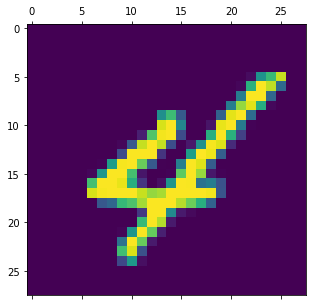

The label is: 4


In [10]:
#Check the imported data
arrayid = 127

matrix = training_data[0][arrayid].reshape(28,28)
fig, ax = plt.subplots(1,1,figsize=(5,5)) #12
im=ax.matshow(matrix,aspect='auto')
plt.show()
print("The label is:",training_data[1][arrayid])


#Check the classifier
#                     0 correct 1 incorrect
#                               |
#matrix = dataset_classifier(5)[0][245].reshape(28,28)
#fig, ax = plt.subplots(1,1,figsize=(5,5)) #12
#im=ax.matshow(matrix,aspect='auto')
#plt.show()



In [11]:
#Create the datasets for the one vs all classifier and one vs one classifier. The digit/s we want to differentiate is the input. 
def dataset_classifier(digits,training_data_):
    #takes a digit as input and outputs the training data, classified based on the digit provided. If two digits are provided 
    #as a list it classifies the training data based on the 2. 
    
    if isinstance(digits, int):
    #one vs all classifier
        positive_label = digits
        #negative label is unnecessary
        
        positive_indices = [i for i, j in enumerate(training_data_[1]) 
                          if j == positive_label]
        negative_indices = [i for i, j in enumerate(training_data_[1]) 
                          if j != positive_label]
        
        positive_dataset = training_data_[0][positive_indices]
        negative_dataset = training_data_[0][negative_indices]
        
        return positive_dataset,negative_dataset
    
    elif (isinstance(digits, list) and len(digits)==2):
    #one vs one classifier
        positive_label = digits[0]
        negative_label = digits[1]
        
        positive_indices = [i for i, j in enumerate(training_data_[1]) 
                          if j == positive_label]
        negative_indices = [i for i, j in enumerate(training_data_[1]) 
                          if j == negative_label]
        
        positive_dataset = training_data_[0][positive_indices]
        negative_dataset = training_data_[0][negative_indices]
        
        return positive_dataset,negative_dataset
        
    else:
        print('Wrong digits input for the dataset classifier')
        
    


In [17]:
def perceptron_training(training_data_):
#creates 10 one vs all classifiers, trains them and stores the weights. The weights are stored as a list of arrays where the 
#digit corresponds with the index of the list.
    weights = []
    for digit in range(0,10):
        positive_dataset,negative_dataset = dataset_classifier(digit,training_data_)
        weights.append(train(positive_dataset, negative_dataset, num_iterations = 100, learning_rate=1))
    return weights

In [18]:
def model_accuracy(weights,test_data_):
#takes a digit from the test data and uses the weights to determine the likelihood of each digit. 
#The largest dot product is the most likely
#returns accuracy
    true_digits = test_data_[1]
    detected_digits = np.zeros(true_digits.shape[0])
    for i,digit in enumerate(test_data_[0]):
        dot_digit = []
        #calculates the dot product for every digit and chooses the maximum as the correct digit
        for n in range(0,10):
            dot_digit.append(np.dot(weights[n],digit))
        detected_digits[i] = dot_digit.index(max(dot_digit))
    #Number of digits correcty predicted
    corr_pred = true_digits[true_digits==detected_digits].shape[0]
    #accuracy
    acc = corr_pred/true_digits.shape[0]
    return acc

In [19]:
def model_accuracy_matrix(weights,test_data_):
#takes a digit from the test data and uses the weights to determine the likelihood of each digit. 
#The largest dot product is the most likely
#returns accuracy
    true_digits = test_data_[1]
    detected_digits = np.zeros(true_digits.shape[0])
    weights_matrix = np.matrix(weights)
    confusion_matrix = np.zeros((10,10))
    #uses a matrix multiplication to obtain the dot product for every digit
    for i,digit in enumerate(test_data_[0]):
        detected_digits[i] = weights_matrix.dot(digit).argmax()
    for tdigit,ddigit in zip(true_digits,detected_digits):
        if ddigit == tdigit:
            confusion_matrix[int(ddigit),int(ddigit)] += 1
        else:
            confusion_matrix[int(ddigit),int(tdigit)] += 1

            
    #Number of digits correcty predicted
    corr_pred = true_digits[true_digits==detected_digits].shape[0]
    #accuracy
    acc = corr_pred/true_digits.shape[0]
    return acc,confusion_matrix

In [20]:
acc = []
acc_bias = []
conf = []
conf_bias = []
import time
start = time.time()

for n in range(10):
    weights = perceptron_training(training_data)
    acc.append(model_accuracy_matrix(weights,test_data)[0])
    conf.append(model_accuracy_matrix(weights,test_data)[1])

    weights = perceptron_training(training_data_bias)
    acc_bias.append(model_accuracy_matrix(weights,test_data_bias)[0])
    conf_bias.append(model_accuracy_matrix(weights,test_data_bias)[1])

print('It took', time.time()-start, 'seconds.')
print('The average accuracy over',n+1,'trials is \n',sum(acc)/len(acc),'for data with no bias term \n',
      sum(acc_bias)/len(acc_bias),'for data with a bias term')

It took 36.48776626586914 seconds.
The average accuracy over 10 trials is 
 0.6711499999999999 for data with no bias term 
 0.7054500000000001 for data with a bias term


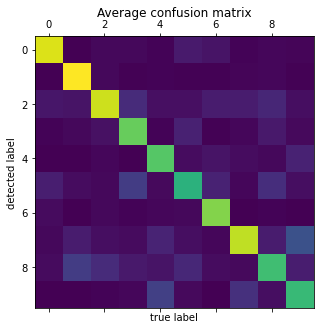

The 10 most mislabeled pairs are:
[7, 9] 2.053 %
[9, 4] 1.561 %
[5, 3] 1.483 %
[8, 1] 1.471 %
[9, 7] 1.149 %
[5, 8] 1.086 %
[8, 2] 1.026 %
[2, 3] 1.025 %
[8, 5] 0.92 %
[2, 8] 0.883 %


In [102]:
sum_conf = sum(conf)
fig, ax = plt.subplots(1,1,figsize=(5,5)) #12
im=ax.matshow(sum_conf,aspect='auto')
plt.title('Average confusion matrix')
plt.xlabel('true label')
plt.ylabel('detected label')
plt.show()
max_conf = [0]
conf_pairs = [0]
N_max = 10
N = sum_conf.sum()/100
for i in range(10):
    for j in range(10):
        if i != j:
            if sum_conf[i,j]/N > max_conf[-1]:
                max_conf.append(sum_conf[i,j]/N)
                conf_pairs.append([i,j])
            elif sum_conf[i,j]/N > max_conf[0]:
                for n,m in enumerate(max_conf[1:]): 
                    if sum_conf[i,j]/N < m:
                        max_conf.insert(n+1,sum_conf[i,j]/N)
                        conf_pairs.insert(n+1,[i,j])
                        break
            if len(max_conf) > N_max:
                max_conf.pop(0)
                conf_pairs.pop(0)

print('The',N_max,'most mislabeled pairs are:')
for pair,perc in zip(list(reversed(conf_pairs)),list(reversed(max_conf))):
    print(pair,perc,'%')

In [105]:
#(1 2 3) (1 0 1)             (4+1  2+0 4+1 )
#(4 5 6) (0 1 0) + (1 0 1) = (10+1 5+0 10+1)
#        (1 0 1)
#bias is added to every row

TV = np.array([[1,2,3],[4,5,6]])
AB = np.array([[1,0,1],[0,1,0],[1,0,1]])
#BIAS = 4*np.ones((1,3)) #(1,n_dim)
BIAS = np.array([1,0,1])[np.newaxis]
OU = np.matmul(TV,AB) + BIAS
OU

array([[ 5,  2,  5],
       [11,  5, 11]])

In [102]:
TV.shape

(2, 3)

In [108]:
for t in training_data[0][0:4]:
    print(t.shape)

(784,)
(784,)
(784,)
(784,)
